# Calories prediction from factors [Gender, Age, Height, Weight, Duration, Heart rate]
### Dataset - https://www.kaggle.com/fmendes/fmendesdat263xdemos

### Experimented by : Bhargavi Kallam, Rajitha Muthukrishnan

#### Step 1: Build models to predict calories and test using test data
#### Step 2: Use apple watch data and predict the calories

Install necessary packages for this notebook execution

In [1]:
!pip install seaborn
!pip install pandas_profiling

# Step 1: Build models
## Data Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics

import xmltodict

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

In [3]:
calories_data = pd.read_csv("data/calories.csv")
exercise_data = pd.read_csv("data/exercise.csv")
exercise_data = exercise_data.drop(columns = 'Body_Temp')

In [4]:
calories_data.head()

User_ID  Calories
0  14733363     231.0
1  14861698      66.0
2  11179863      26.0
3  16180408      71.0
4  17771927      35.0

In [5]:
exercise_data.head()

User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate
0  14733363    male   68   190.0    94.0      29.0       105.0
1  14861698  female   20   166.0    60.0      14.0        94.0
2  11179863    male   69   179.0    79.0       5.0        88.0
3  16180408  female   34   179.0    71.0      13.0       100.0
4  17771927  female   27   154.0    58.0      10.0        81.0

## Dataset and Analysis

In [6]:
data = pd.concat([exercise_data, calories_data['Calories']], axis=1)
data.shape

(15000, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Calories    15000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 937.6+ KB


In [8]:
data.head()

User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Calories
0  14733363    male   68   190.0    94.0      29.0       105.0     231.0
1  14861698  female   20   166.0    60.0      14.0        94.0      66.0
2  11179863    male   69   179.0    79.0       5.0        88.0      26.0
3  16180408  female   34   179.0    71.0      13.0       100.0      71.0
4  17771927  female   27   154.0    58.0      10.0        81.0      35.0

<AxesSubplot:>

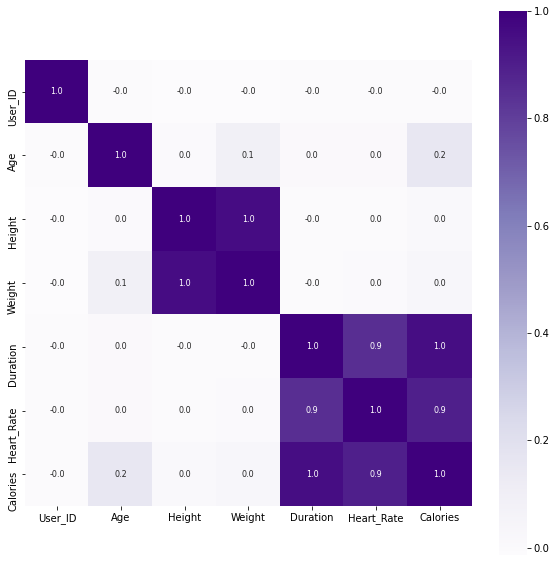

In [9]:
correlation = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Purples')

In [10]:
data.replace({'Gender':{'male':0,'female':1}},inplace=True)
data.head()

User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Calories
0  14733363       0   68   190.0    94.0      29.0       105.0     231.0
1  14861698       1   20   166.0    60.0      14.0        94.0      66.0
2  11179863       0   69   179.0    79.0       5.0        88.0      26.0
3  16180408       1   34   179.0    71.0      13.0       100.0      71.0
4  17771927       1   27   154.0    58.0      10.0        81.0      35.0

## pandas_profiling

It allows building reports for datasets with a variety of features and customizations.

##### - OVERVIEW 

Statistical overview includes the number of variables, Number of observation, Missing cells, percentage of missing cells, Duplicate rows, percentage of duplicate rows, and Total size in memo.

#####  - VARIABLES 

Analyzes all variables/columns/features of the dataset. The information presented varies according to the type of data. 

#####  - CORRELATION 

The term "correlation" refers to the degree to which two variables move in lockstep with one another.


In [11]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data)
profile

## Model

Separate features and target value to be predicted

In [12]:
X = data.drop(['User_ID','Calories'],axis=1)
Y = data['Calories']

The dataset is split into train(80%) and test data(20%) for validation of the model using train_test_split.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)
print('X:' + str(X.shape) + '\nX_train:' + str(X_train.shape) + '\nX_test' + str(X_test.shape))

X:(15000, 6)
X_train:(12000, 6)
X_test(3000, 6)


Methods for analysis

1. plot_predictions :
     Is a scatter plot enables to analyse the predicions made by models.
            
2. Metrics :
     Calculate mean_absolute_error and r2_score metris.

In [14]:
# To analyse the predictions
def plot_predictions(preds):
    plt.style.use(['dark_background'])
    fig = plt.figure(figsize=(10,7),facecolor='b',edgecolor='g')
    plt.scatter(Y_test,preds ,s=10,c='g',label='Predicted') 
    plt.plot(Y_test,Y_test,'white' ,label='Test' ,linewidth=2.0)
    plt.legend(fontsize=20)
    plt.show()
    
mae_all =[]
r2_all  =[]

# Metrics for evaluating the model
def Metrics(preds):
    mae = metrics.mean_absolute_error(Y_test, preds)
    r2 = metrics.r2_score(Y_test, preds)
    mae_all.append(mae)
    r2_all.append(r2)

            
#### Regression Models:
 
 1. XGBoost Regressor
 2. Quadratic Regression with PolynomialFeatures
 3. DecisionTree Regressor
 4. RandomForest Regressor
 5. Neural Networks

### XGBoost Regressor

In [15]:
xg_model = XGBRegressor()

xg_model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
test_pred = xg_model.predict(X_test)
Metrics(test_pred)

Plot for XGBoostRegressor : 


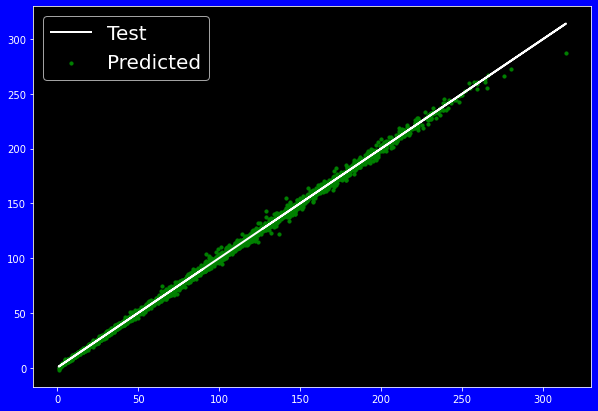

In [17]:
print("Plot for XGBoostRegressor : ")
plot_predictions(test_pred)

### Quadratic Regression with PolynomialFeatures

In [18]:
# Create regression object
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

Model = linear_model.LinearRegression()

Model_poly = PolynomialFeatures(degree=4)
X_trn_pl = Model_poly.fit_transform(X_train)
X_tst_pl = Model_poly.fit_transform(X_test)


# Train the model using the training sets
Model.fit(X_trn_pl,Y_train)

C_mq_tst = Model.predict(X_tst_pl)
C_mq_trn = Model.predict(X_trn_pl)
r2_poly = metrics.r2_score(Y_test, C_mq_tst)

Metrics(C_mq_tst)


Plot for Quadratic Regression with PolynomialFeatures : 


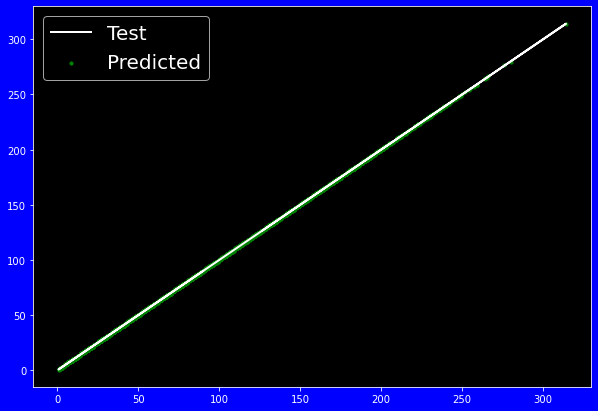

In [19]:
print("Plot for Quadratic Regression with PolynomialFeatures : ")
plot_predictions(C_mq_tst)

### DecisionTreeRegressor

In [20]:
from sklearn.tree import DecisionTreeRegressor

Model_DT = DecisionTreeRegressor(random_state=42)

# Train the model using the training sets
Model_DT.fit(X_train, Y_train)

# predeiction on test data
preds_DT = Model_DT.predict(X_test)

# metrics for test data
Metrics(preds_DT)

Plot for DecisionTreeRegressor : 


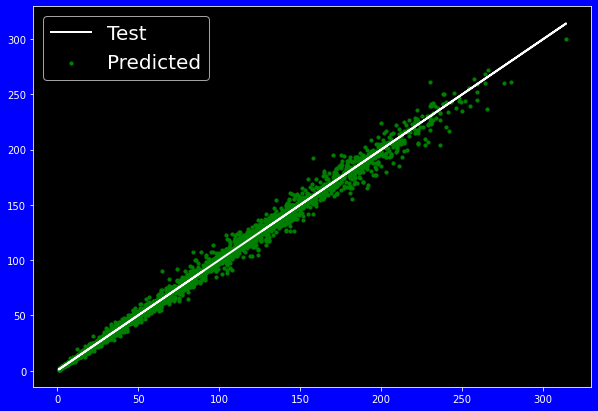

In [21]:
print("Plot for DecisionTreeRegressor : ")
plot_predictions(preds_DT)

### RandomForestRegressor

In [22]:
from sklearn.ensemble import RandomForestRegressor

Model_RF = RandomForestRegressor(n_estimators=30, random_state=42)

# Train the model using the training sets
Model_RF.fit(X_train, Y_train)

# prediction on test data
preds = Model_RF.predict(X_test)

# metrics for test data
Metrics(preds)

Plot for RandomForestRegressor : 


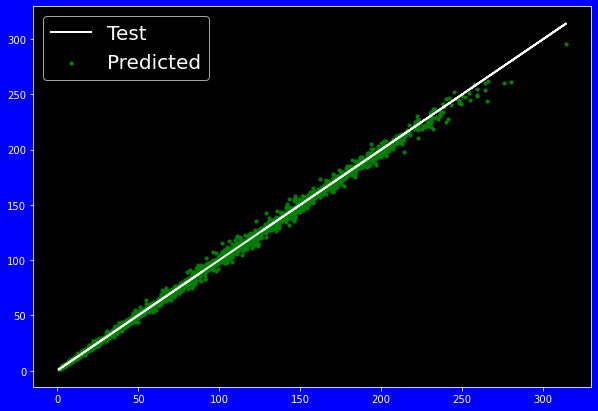

In [23]:
print("Plot for RandomForestRegressor : ")
plot_predictions(preds)

### Neural Networks

In [24]:
# Initializing the NN model
NN_model = Sequential()

# Adding Input layers to the model
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# Adding Hidden layers to the model
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# Adding Output layers to the model
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))


In [25]:
# Compiling the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Training the model Network
history = NN_model.fit(x=X_train, y=Y_train, epochs=10, batch_size=64,validation_split=0.2, verbose=0)

In [29]:
# prediction on test data
preds_nn = NN_model.predict(X_test)

# metrics for test data
Metrics(preds_nn)

### Scores of models

In [30]:
List = ['XGBoost Regressor','Quadratic Regressor', 'DecisionTreeRegressor','RandomForestRegressor','Neural Networks']

Metrics_df = pd.DataFrame({'Model':List,'Mean_Absolute_error':mae_all, 'R2_score':r2_all})
Metrics_df

Model  Mean_Absolute_error  R2_score
0      XGBoost Regressor             1.446692  0.998844
1    Quadratic Regressor             0.252749  0.999978
2  DecisionTreeRegressor             3.177667  0.993702
3  RandomForestRegressor             1.688189  0.998205
4        Neural Networks             5.932441  0.981606

# Step 2: Predict for data from Apple Health

The test-data is real-time data from Apple watch's health data. The columns "Duration" and "Heart-rate" are extracted and other general columns('Gender', 'Age', 'Height', 'Weight') are manually created. 

### Import Apple Health data

In [32]:
input_path = 'Wearables_data/apple_health_export/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())
    
# Records list for general health data & imported as Pandas Data Frame
records_list = input_data['HealthData']['Record']
df_records = pd.DataFrame(records_list)

### Extract data

In [33]:
# Extract records with heart rate values
heartrate_records = df_records[df_records['@unit']=='count/min']

# Calculate duration from start and end time
heartrate_records['Duration'] = pd.to_datetime(heartrate_records['@endDate']) - pd.to_datetime(heartrate_records['@startDate'])
heartrate_records['Duration'] = pd.to_timedelta(heartrate_records['Duration']).astype('timedelta64[m]').astype(int)

In [34]:
# Extract the necessary features
test_data = heartrate_records[['Duration', '@value']]
test_data = test_data.rename(columns= {'@value':'Heart_Rate'})

In [35]:
# Add personal data values
test_data['Gender'] = 'female'
test_data['Age'] = 25
test_data['Height'] = 160
test_data['Weight'] = 54

# Final processing
test_data = test_data[['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate']]
test_data.replace({'Gender':{'male':0,'female':1}},inplace=True)
test_data.head()

# Change datatypes
test_data = test_data.astype({'Height':'float64','Weight':'float64','Duration':'float64','Heart_Rate':'float64'})

# Extract necessary data samples

# Remove samples with 0 minutes duration or less than 60 seconds and more than 60 minutes
test_data = test_data[(test_data.Duration != 0) & (test_data.Duration < 60)].reset_index(drop = True)

# Heart rate must be between 122 and 200 bpm
test_data = test_data[(test_data.Heart_Rate > 122) & (test_data.Heart_Rate < 200)]

print('Number of samples from Apple watch : ', test_data.shape[0])

Number of samples from Apple watch :  34


### Predict calories for data from Apple watch

In [36]:
prediction = xg_model.predict(test_data)

#### Samples and predictions
Verify : http://www.shapesense.com/fitness-exercise/calculators/heart-rate-based-calorie-burn-calculator.shtml

In [37]:
estimated_output = ['159','168','113','174','182','137','71','107','85','153','137','27','128','48','336','170','387','335','128','368','238','379','513','465','31','154','393','469','525','449','282','205','449','674'] 

In [38]:
# Prediction for Qadrtic regression 
X_tst_pl_new = Model_poly.fit_transform(test_data)

prediction_quad = Model.predict(X_tst_pl_new)

apple_data_pred = test_data
apple_data_pred['Predicted calories'] = prediction_quad
apple_data_pred['Estimated calories'] = estimated_output

apple_data_pred.head()

Gender  Age  Height  Weight  Duration  Heart_Rate  Predicted calories  \
0       1   25   160.0    54.0      17.0     135.898          158.369238   
2       1   25   160.0    54.0      15.0     153.854          165.535982   
3       1   25   160.0    54.0       9.0     166.268          104.001456   
4       1   25   160.0    54.0      16.0     149.771          170.833836   
5       1   25   160.0    54.0      16.0     154.715          178.181385   

  Estimated calories  
0                159  
2                168  
3                113  
4                174  
5                182

In [39]:
mae = metrics.mean_absolute_error(Y_test, preds)
r2 = metrics.r2_score(Y_test, preds)
print("Mean Absolute Error for test data= ",mae)
print("R2-Score for test data = ",r2)

Mean Absolute Error for test data=  1.688188888888889
R2-Score for test data =  0.9982052356914956


## Save model

As from the above metrics and plots, it is clear that Quadratic Regressor works better than other models.

In [40]:
import pickle

In [41]:
pickle.dump(Model, open("prediction_model.pkl", "wb"))